Objective:
Learn what matters most for winning college basketball games using team averages going into each game, not single-game box scores. Focus on regular season (will expand when March Madness seeding comes out), home/away/neutral context, and providing normalized weights (sum to 1) for interpretability.

We want to use pregame averages to avoid being misled by fluky single-game performances (e.g., a rare 80% FG game). Using expanding means shifted by one game ensures every feature is truly known pre-tipoff and reflects the team's underlying tendencies. The "law of averages" always wins.

Modeling plan:  
- Train on 2019–2023, test on 2024 (modern era stability, avoids outdated patterns).  
- Two models:
  - Logistic Regression (with standardization): gives directional, linear, interpretable coefficients.
  - XGBoost: captures nonlinearities/interactions and provides gain importances.
- Export normalized importances which will go into actual prediction model:
  - Logistic: absolute standardized coefficients → normalized to sum to 1.
  - XGB: gain importances → normalized to sum to 1.

Use these weights in the actual prediction model that uses API calls for current-team stats.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.model_selection import train_test_split

import xgboost as xgb #good for tabular data
from xgboost.callback import EarlyStopping

#Matplotlib defaults
plt.rcParams.update({"figure.figsize": (7,5), "axes.grid": True})
pd.set_option("display.max_columns", 150)

#Project paths
DATA_DIR = Path("../data/kaggle_2025")
ARTIFACTS = Path("models"); ARTIFACTS.mkdir(parents=True, exist_ok=True)
IMAGES = Path("images"); IMAGES.mkdir(parents=True, exist_ok=True)

#Train on 2019–2023 and evaluate on 2024
SEASON_MIN  = 2019
SEASON_MAX  = 2024
TEST_SEASON = 2024 


In [2]:

#Data Loading

rs = pd.read_csv(DATA_DIR / "MRegularSeasonDetailedResults.csv")
teams = pd.read_csv(DATA_DIR / "MTeams.csv")  # not essential for modeling here but useful for lookups

#Filter
rs = rs[(rs["Season"] >= SEASON_MIN) & (rs["Season"] <= SEASON_MAX)].copy()

#Sanity cehck: core keys and location
rs[['Season','DayNum','WTeamID','LTeamID','WLoc']].head()


,Season,DayNum,WTeamID,LTeamID,WLoc
82041,2019,1,1104,1380,H
82042,2019,1,1113,1168,H
82043,2019,1,1119,1265,H
82044,2019,1,1120,1375,H
82045,2019,1,1123,1232,H


In [3]:

#Transform to team-perspective rows (winner and loser sides)

#Compute advanced stats for each side of each game
#Per-team per-game observations, helps compute pregame averages later

def poss(FGA, OR, TO, FTA):
    return (FGA - OR + TO + 0.475 * FTA).replace(0, np.nan)

def make_side_frames(df):
    
    #Compute possessions for both sides (vectorized)
    WPoss = poss(df["WFGA"], df["WOR"], df["WTO"], df["WFTA"])
    LPoss = poss(df["LFGA"], df["LOR"], df["LTO"], df["LFTA"])

    #Winner-side view (offense = W*, defense = L*)
    W = pd.DataFrame({
        "Season": df["Season"], "DayNum": df["DayNum"], "TeamID": df["WTeamID"],
        # location from winner perspective
        "home_advantage": df["WLoc"].map({"H":1, "A":-1, "N":0}).astype(float),

        #tempo / efficiency
        "Poss": WPoss,
        "OffRating": 100.0 * df["WScore"] / WPoss,
        "DefRating": 100.0 * df["LScore"] / LPoss,

        #offense (winner)
        "Off_eFG":   (df["WFGM"] + 0.5*df["WFGM3"]) / df["WFGA"].replace(0, np.nan),
        "Off_3P%":   df["WFGM3"] / df["WFGA3"].replace(0, np.nan),
        "Off_2P%":  (df["WFGM"] - df["WFGM3"]) / (df["WFGA"] - df["WFGA3"]).replace(0, np.nan),
        "Off_FT%":   df["WFTM"] / df["WFTA"].replace(0, np.nan),
        "Off_3PA%":  df["WFGA3"] / df["WFGA"].replace(0, np.nan),
        "Off_TOV%":  df["WTO"] / WPoss,
        "Off_FTR":   df["WFTA"] / df["WFGA"].replace(0, np.nan),
        "Off_A%":    df["WAst"] / df["WFGM"].replace(0, np.nan),
        "Off_OR%":   df["WOR"]  / (df["WOR"] + df["LDR"]).replace(0, np.nan),

        #defense (against loser)
        "Def_eFG_allowed":  (df["LFGM"] + 0.5*df["LFGM3"]) / df["LFGA"].replace(0, np.nan),
        "Def_3P%_allowed":  df["LFGM3"] / df["LFGA3"].replace(0, np.nan),
        "Def_2P%_allowed": (df["LFGM"] - df["LFGM3"]) / (df["LFGA"] - df["LFGA3"]).replace(0, np.nan),
        "Def_FT%_allowed":  df["LFTM"] / df["LFTA"].replace(0, np.nan),
        "Def_3PA%_allowed": df["LFGA3"] / df["LFGA"].replace(0, np.nan),
        "Def_TOV%":         df["LTO"] / LPoss,                       # turnovers forced
        "Def_DR%":          df["WDR"] / (df["WDR"] + df["LOR"]).replace(0, np.nan),
        "Def_BLK%":         df["WBlk"] / (df["LFGA"] - df["LFGA3"]).replace(0, np.nan),
        "Def_STL%":         df["WStl"] / LPoss,
    })

    #Loser-side view (offense = L*, defense = W*)
    L = pd.DataFrame({
        "Season": df["Season"], "DayNum": df["DayNum"], "TeamID": df["LTeamID"],
        # location from loser perspective (invert WLoc)
        "home_advantage": df["WLoc"].map({"H":-1, "A":1, "N":0}).astype(float),

        "Poss": LPoss,
        "OffRating": 100.0 * df["LScore"] / LPoss,
        "DefRating": 100.0 * df["WScore"] / WPoss,

        "Off_eFG":   (df["LFGM"] + 0.5*df["LFGM3"]) / df["LFGA"].replace(0, np.nan),
        "Off_3P%":   df["LFGM3"] / df["LFGA3"].replace(0, np.nan),
        "Off_2P%":  (df["LFGM"] - df["LFGM3"]) / (df["LFGA"] - df["LFGA3"]).replace(0, np.nan),
        "Off_FT%":   df["LFTM"] / df["LFTA"].replace(0, np.nan),
        "Off_3PA%":  df["LFGA3"] / df["LFGA"].replace(0, np.nan),
        "Off_TOV%":  df["LTO"] / LPoss,
        "Off_FTR":   df["LFTA"] / df["LFGA"].replace(0, np.nan),
        "Off_A%":    df["LAst"] / df["LFGM"].replace(0, np.nan),
        "Off_OR%":   df["LOR"]  / (df["LOR"] + df["WDR"]).replace(0, np.nan),

        "Def_eFG_allowed":  (df["WFGM"] + 0.5*df["WFGM3"]) / df["WFGA"].replace(0, np.nan),
        "Def_3P%_allowed":  df["WFGM3"] / df["WFGA3"].replace(0, np.nan),
        "Def_2P%_allowed": (df["WFGM"] - df["WFGM3"]) / (df["WFGA"] - df["WFGA3"]).replace(0, np.nan),
        "Def_FT%_allowed":  df["WFTM"] / df["WFTA"].replace(0, np.nan),
        "Def_3PA%_allowed": df["WFGA3"] / df["WFGA"].replace(0, np.nan),
        "Def_TOV%":         df["WTO"] / WPoss,
        "Def_DR%":          df["LDR"] / (df["LDR"] + df["WOR"]).replace(0, np.nan),
        "Def_BLK%":         df["LBlk"] / (df["WFGA"] - df["WFGA3"]).replace(0, np.nan),
        "Def_STL%":         df["LStl"] / WPoss,
    })

    out = pd.concat([W, L], ignore_index=True).sort_values(["Season","TeamID","DayNum"])
    return out

team_games = make_side_frames(rs)
team_games.head(3)



,Season,DayNum,TeamID,home_advantage,Poss,OffRating,DefRating,Off_eFG,Off_3P%,Off_2P%,Off_FT%,Off_3PA%,Off_TOV%,Off_FTR,Off_A%,Off_OR%,Def_eFG_allowed,Def_3P%_allowed,Def_2P%_allowed,Def_FT%_allowed,Def_3PA%_allowed,Def_TOV%,Def_DR%,Def_BLK%,Def_STL%
116,2019,4,1101,1.0,75.725,124.133377,96.816976,0.636364,0.571429,0.560976,0.774194,0.254545,0.237702,0.563636,0.548387,0.400000,0.491525,0.352941,0.476190,0.625000,0.288136,0.212202,0.717949,0.000000,0.106101
373,2019,10,1101,-1.0,60.600,110.561056,99.632503,0.551020,0.416667,0.480000,0.812500,0.489796,0.148515,0.326531,0.727273,0.178571,0.578431,0.600000,0.444444,0.181818,0.294118,0.244998,0.677419,0.138889,0.081666
744,2019,17,1101,0.0,55.850,128.916741,101.771922,0.616071,0.611111,0.473684,0.500000,0.321429,0.107431,0.107143,0.655172,0.310345,0.537500,0.350000,0.550000,0.684211,0.500000,0.199909,0.800000,0.050000,0.072694


In [4]:

#Compute pregame averages (important to avoid leakage)
#Compute expanding means and then shift by one game: current game's features only reflect information available 
    #*before* the game tipped off.

off_cols = ["OffRating","Off_eFG","Off_3P%","Off_2P%","Off_FT%","Off_3PA%","Off_TOV%","Off_FTR","Off_A%","Off_OR%"]
def_cols = ["DefRating","Def_eFG_allowed","Def_3P%_allowed","Def_2P%_allowed","Def_FT%_allowed",
            "Def_3PA%_allowed","Def_TOV%","Def_DR%","Def_BLK%","Def_STL%"]
tempo_cols = ["Poss"]
carry_cols = ["home_advantage"]

def pregame_shift_means(df, cols):
    df = df.sort_values(["Season","TeamID","DayNum"]).copy()
    g  = df.groupby(["Season","TeamID"], group_keys=False)
    for c in cols:
        if c in carry_cols:  #context, not averaged
            continue
        df[c + "_pre"] = g[c].apply(lambda s: s.expanding().mean().shift(1))
    return df

team_pregame = pregame_shift_means(team_games, off_cols + def_cols + tempo_cols)

In [5]:

#Build training rows
#Each original game adds TWO rows to the dataset
#   (A) Winner perspective = 1
#   (B) Loser perspective = 0
#Features are diffs of pregame averages: (TeamA - TeamB) + TeamA home_advantage.


base = rs[["Season","DayNum","WTeamID","LTeamID","WLoc"]].copy()
idx  = team_pregame.set_index(["Season","TeamID","DayNum"])

def fetch(s,t,d):
    try: return idx.loc[(s,t,d)]
    except KeyError: return None

rows = []
for _, r in base.iterrows():
    s, d = int(r["Season"]), int(r["DayNum"])
    w, l = int(r["WTeamID"]), int(r["LTeamID"])

    a = fetch(s,w,d); b = fetch(s,l,d)
    if a is not None and b is not None:
        row = {"Season": s, "DayNum": d, "TeamA": w, "TeamB": l, "TeamA_Wins": 1,
               "home_advantage": float(a["home_advantage"])}
        for c in off_cols + def_cols + tempo_cols:
            row[c+"_diff"] = float(a.get(c+"_pre", np.nan) - b.get(c+"_pre", np.nan))
        rows.append(row)

    a = fetch(s,l,d); b = fetch(s,w,d)
    if a is not None and b is not None:
        row = {"Season": s, "DayNum": d, "TeamA": l, "TeamB": w, "TeamA_Wins": 0,
               "home_advantage": float(a["home_advantage"])}
        for c in off_cols + def_cols + tempo_cols:
            row[c+"_diff"] = float(a.get(c+"_pre", np.nan) - b.get(c+"_pre", np.nan))
        rows.append(row)

df_final = pd.DataFrame(rows).dropna().reset_index(drop=True)
print(df_final.shape)
df_final.head(4)


(59746, 27)


,Season,DayNum,TeamA,TeamB,TeamA_Wins,home_advantage,OffRating_diff,Off_eFG_diff,Off_3P%_diff,Off_2P%_diff,Off_FT%_diff,Off_3PA%_diff,Off_TOV%_diff,Off_FTR_diff,Off_A%_diff,Off_OR%_diff,DefRating_diff,Def_eFG_allowed_diff,Def_3P%_allowed_diff,Def_2P%_allowed_diff,Def_FT%_allowed_diff,Def_3PA%_allowed_diff,Def_TOV%_diff,Def_DR%_diff,Def_BLK%_diff,Def_STL%_diff,Poss_diff
0,2019,3,1323,1152,1,1.0,38.851827,0.028763,-0.056277,0.091026,0.375940,0.004839,-0.045081,0.262903,-0.229665,0.211180,-38.592224,-0.194067,-0.126437,-0.152381,0.074242,0.148777,0.013018,0.160256,0.158333,-0.069456,-1.925
1,2019,3,1152,1323,0,-1.0,-38.851827,-0.028763,0.056277,-0.091026,-0.375940,-0.004839,0.045081,-0.262903,0.229665,-0.211180,38.592224,0.194067,0.126437,0.152381,-0.074242,-0.148777,-0.013018,-0.160256,-0.158333,0.069456,1.925
2,2019,3,1355,1106,1,1.0,34.279770,0.097649,0.065611,0.132885,0.215385,-0.179624,-0.061538,0.266458,-0.264286,0.152047,-8.691637,-0.145096,-0.119910,-0.119919,0.135714,0.097655,-0.113526,0.084515,0.037940,-0.014702,1.600
3,2019,3,1106,1355,0,-1.0,-34.279770,-0.097649,-0.065611,-0.132885,-0.215385,0.179624,0.061538,-0.266458,0.264286,-0.152047,8.691637,0.145096,0.119910,0.119919,-0.135714,-0.097655,0.113526,-0.084515,-0.037940,0.014702,-1.600


In [6]:
# --- Features & target ---
feature_cols = ["home_advantage"] + [f"{c}_diff" for c in off_cols + def_cols + tempo_cols]
target_col   = "TeamA_Wins"

In [7]:

# --- Train/Test split by season ---
train_mask = df_final["Season"] < TEST_SEASON
test_mask  = df_final["Season"] == TEST_SEASON

X_train, y_train = df_final.loc[train_mask, feature_cols], df_final.loc[train_mask, target_col].astype(int)
X_test,  y_test  = df_final.loc[test_mask,  feature_cols], df_final.loc[test_mask,  target_col].astype(int)

X_train.shape, X_test.shape


((48968, 22), (10778, 22))

In [8]:

#Modeling: Logistic (linear, interpretable) and XGB (nonlinear)


#Validation split from training seasons for XGB
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

#Logistic regression
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, C=1.0, solver="lbfgs"))
]).fit(X_tr, y_tr)

#XGBoost configuration chosen for a balance between bias/variance and stability
xgb_clf = xgb.XGBClassifier(
    n_estimators=600,           #a bit lower to reduce overfitting, tested 400, 600, 800, 600 was overall best
    learning_rate=0.03,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1,
    eval_metric="logloss",
    random_state=42
)

xgb_clf.fit(X_tr, y_tr)  # <- no callbacks, no early_stopping_rounds, no eval_set

def evaluate(model, X, y):
    p = model.predict_proba(X)[:, 1]
    return {
        "AUC": float(roc_auc_score(y, p)),
        "Brier": float(brier_score_loss(y, p)),
        "LogLoss": float(log_loss(y, p)),
    }

print("Validation metrics (slice of 2019–2023):")
print("  Logistic:", evaluate(logreg, X_val, y_val))
print("  XGBoost :", evaluate(xgb_clf, X_val, y_val))

print("\nTEST metrics (2024):")
print("  Logistic:", evaluate(logreg, X_test, y_test))
print("  XGBoost :", evaluate(xgb_clf, X_test, y_test))

Validation metrics (slice of 2019–2023):
  Logistic: {'AUC': 0.7816255534471853, 'Brier': 0.19087715887643925, 'LogLoss': 0.5640754599107426}
  XGBoost : {'AUC': 0.7802581986244885, 'Brier': 0.19078949802965153, 'LogLoss': 0.5606196866158089}

TEST metrics (2024):
  Logistic: {'AUC': 0.7722513035822303, 'Brier': 0.19411758047478964, 'LogLoss': 0.5708622630268555}
  XGBoost : {'AUC': 0.7743547375134898, 'Brier': 0.1930741831175168, 'LogLoss': 0.5658503609587604}


In [9]:

#Export normalized importances (sum to 1)

#Logistic: absolute coefficient magnitudes on standardized inputs
coef = np.abs(logreg.named_steps["clf"].coef_.ravel())
log_cols = list(X_train.columns)
sum_coef = coef.sum() if coef.sum() != 0 else 1.0
logistic_weights = {col: float(w / sum_coef) for col, w in zip(log_cols, coef)}

with open(ARTIFACTS / "weights_logistic_normalized.json", "w") as f:
    json.dump(logistic_weights, f, indent=2)

#XGBoost: gain importances normalized to sum to 1
gain_raw = xgb_clf.get_booster().get_score(importance_type="gain")  # dict: {feature_name or 'f0': gain}

#Handle both naming styles:
if all(k.startswith("f") and k[1:].isdigit() for k in gain_raw.keys()):
    # Keys are 'f0', 'f1', ... -> map by index to column names
    idx_to_col = {i: c for i, c in enumerate(list(X_train.columns))}
    gain_named = {idx_to_col[int(k[1:])]: v for k, v in gain_raw.items()}
else:
    #Keys are already real feature names
    gain_named = dict(gain_raw)

#Include zero for any feature not used by the model (so weights cover all features)
for col in X_train.columns:
    gain_named.setdefault(col, 0.0)

sum_gain = sum(gain_named.values()) if sum(gain_named.values()) != 0 else 1.0
xgb_weights = {k: float(v / sum_gain) for k, v in gain_named.items()}

with open(ARTIFACTS / "weights_xgb_gain_normalized.json", "w") as f:
    json.dump(xgb_weights, f, indent=2)

print("Top Logistic weights:")
print(sorted(logistic_weights.items(), key=lambda kv: kv[1], reverse=True)[:10])

print("\nTop XGB gain weights:")
print(sorted(xgb_weights.items(), key=lambda kv: kv[1], reverse=True)[:10])



Top Logistic weights:
[('DefRating_diff', 0.2404224862759227), ('OffRating_diff', 0.20246937239474375), ('home_advantage', 0.15531183036666657), ('Off_OR%_diff', 0.0409042037705511), ('Def_eFG_allowed_diff', 0.040497953359216556), ('Off_2P%_diff', 0.04000111116179859), ('Off_eFG_diff', 0.03641040302101536), ('Def_3P%_allowed_diff', 0.033379380847828634), ('Off_TOV%_diff', 0.03274424678652874), ('Def_STL%_diff', 0.031181859424032378)]

Top XGB gain weights:
[('OffRating_diff', 0.28828543044050386), ('home_advantage', 0.19584744314202218), ('DefRating_diff', 0.16810219041500649), ('Def_2P%_allowed_diff', 0.03281587449759372), ('Off_OR%_diff', 0.0313025982917157), ('Off_eFG_diff', 0.027230660701432523), ('Off_2P%_diff', 0.02485470673116423), ('Def_STL%_diff', 0.023934932198387215), ('Def_eFG_allowed_diff', 0.02293025747307759), ('Def_DR%_diff', 0.021666110778227454)]


<Figure size 700x500 with 0 Axes>

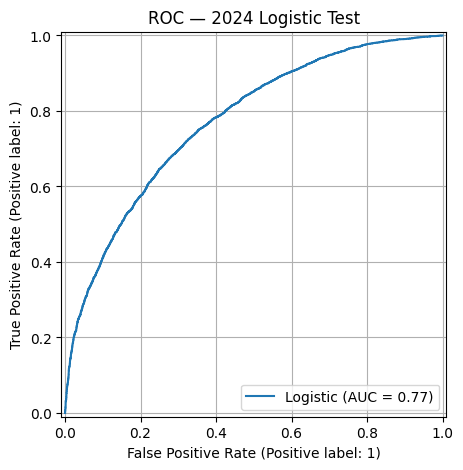

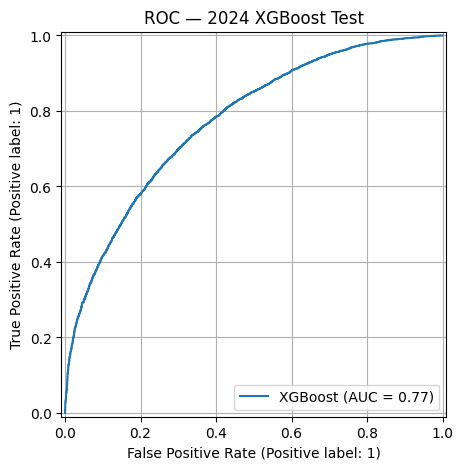

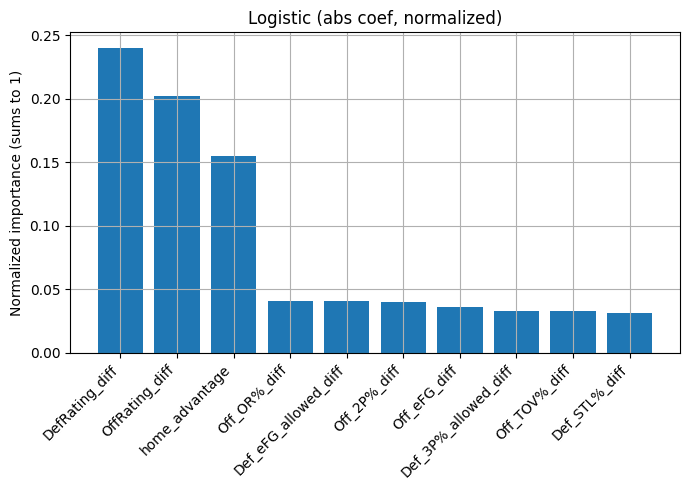

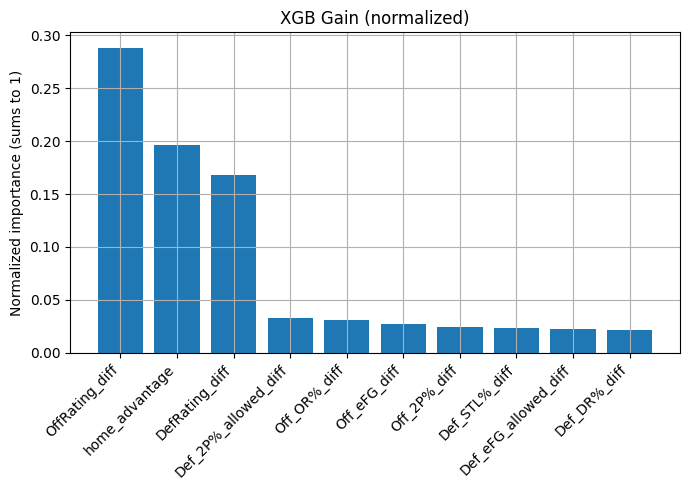

In [10]:

#Visuals
from sklearn.metrics import RocCurveDisplay

# ROC on 2024 hold-out
plt.figure()
RocCurveDisplay.from_estimator(logreg, X_test, y_test, name="Logistic")
plt.title("ROC — 2024 Logistic Test")
plt.savefig(IMAGES / "roc_Logistic_test_2024.png", bbox_inches="tight"); plt.show()
RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test, name="XGBoost")
plt.title("ROC — 2024 XGBoost Test")
plt.savefig(IMAGES / "roc_XGBoost_test_2024.png", bbox_inches="tight"); plt.show()

def plot_top_weights(weights_dict, title, out_path, topn=10):
    items = sorted(weights_dict.items(), key=lambda kv: kv[1], reverse=True)[:topn]
    labels = [k for k,_ in items]
    vals = [v for _,v in items]
    plt.figure()
    plt.bar(labels, vals)
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.ylabel("Normalized importance (sums to 1)")
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight"); plt.show()

plot_top_weights(logistic_weights, "Logistic (abs coef, normalized)", IMAGES / "logistic_top_weights.png")
plot_top_weights(xgb_weights, "XGB Gain (normalized)", IMAGES / "xgb_top_weights.png")


In [11]:
#Export full Logistic model for live usage (prediction model)
from pathlib import Path
import json
ARTIFACTS = Path("models"); ARTIFACTS.mkdir(exist_ok=True, parents=True)

#feature names
feature_names = list(X_train.columns)

#scaler params
scaler = logreg.named_steps["scaler"]
scaler_mean  = dict(zip(feature_names, scaler.mean_))
scaler_scale = dict(zip(feature_names, scaler.scale_))

#logistic coefficients (+ intercept)
coef_signed = logreg.named_steps["clf"].coef_.ravel().tolist()
intercept   = float(logreg.named_steps["clf"].intercept_[0])

# 4)dump to JSON
(json.dumps(feature_names) and None)  # noop to ensure it's serializable
with open(ARTIFACTS / "logistic_signed_coefficients.json", "w") as f:
    json.dump(dict(zip(feature_names, coef_signed)), f, indent=2)

with open(ARTIFACTS / "logistic_model_meta.json", "w") as f:
    json.dump({"feature_names": feature_names, "intercept": intercept}, f, indent=2)

with open(ARTIFACTS / "scaler_mean.json", "w") as f:
    json.dump(scaler_mean, f, indent=2)

with open(ARTIFACTS / "scaler_scale.json", "w") as f:
    json.dump(scaler_scale, f, indent=2)

print("Exported Logistic artifacts to models/:",
      ["logistic_signed_coefficients.json",
       "logistic_model_meta.json",
       "scaler_mean.json", "scaler_scale.json"])


Exported Logistic artifacts to models/: ['logistic_signed_coefficients.json', 'logistic_model_meta.json', 'scaler_mean.json', 'scaler_scale.json']
